In [511]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [512]:
def options_chain(symbol):

    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt['expirationDate'] = e
        options = options.append(opt, ignore_index=True)

    # Boolean column if the option is a CALL
    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)

    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['mark'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask

    # Drop unnecessary and meaningless columns
    options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])

    return options
def get_current_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]

In [513]:
stock = 'XLE'
S = int(get_current_price(stock))

In [514]:
options = options_chain(stock)

In [515]:
options = options.rename(columns={'impliedVolatility':'iv'})
options['expirationDate'] = pd.to_datetime(options['expirationDate'])
options['DTE'] = options.expirationDate - dt.datetime.today() #adding days to expiration
options['DTE'] = pd.to_numeric(options['DTE'].dt.days, downcast='integer') #getting as day int
options['DTE'] = options['DTE'] + 1
options = options[options.DTE < 300]

In [516]:
calls = options[options.CALL == True]
puts = options[options.CALL == False]
calls['Moneyness'] = (( S - calls.strike ) / S ) * 100 #Adding % out/in the money column (moneyness)
puts['Moneyness'] = (( puts.strike - S ) / S ) * 100

In [517]:
closest = abs(0 - calls.Moneyness).min() #finding closest moneyness
closest1 =  abs(0 - puts.Moneyness).min()

In [518]:
ATM_Calls = calls[(calls.Moneyness == closest) | (calls.Moneyness == -closest)] #filtering to closest moneyness for each DTE
ATM_Puts = puts[(puts.Moneyness == closest1) | (puts.Moneyness == -closest1)]

In [519]:
data = []

for (_, aCall) ,(_,aPut) in zip(ATM_Calls.iterrows(), ATM_Puts.iterrows()):

    if aCall.DTE != aPut.DTE:
        continue

    straddle_price = aCall.mark + aPut.mark
    iv = (aCall.iv + aPut.iv) / 2
    data.append([aCall.DTE, straddle_price, iv])
straddles = pd.DataFrame(data, columns=["DTE", "price", "iv"])
straddles

,DTE,price,iv
0,1,1.200,0.243660
1,9,2.895,0.278205
2,16,3.985,0.293952
3,23,4.905,0.303840
4,30,5.670,0.312629
5,37,6.285,0.310493
6,44,6.825,0.312019
7,65,8.375,0.315437
8,128,11.775,0.317725
9,156,12.975,0.317084


In [520]:
straddles['85_method'] = straddles.price * .85

In [521]:
straddles['iv_method'] = S * straddles.iv * np.sqrt(straddles.DTE/252)

In [522]:
straddles_negative = straddles.copy()

In [523]:
straddles_negative['85_method'] = straddles_negative['85_method'] * -1 #negative because +- move
straddles['iv_method'] = straddles['iv_method'] * -1

In [524]:
combined = straddles.append(straddles_negative)

Text(0.5, 0, 'DTE')

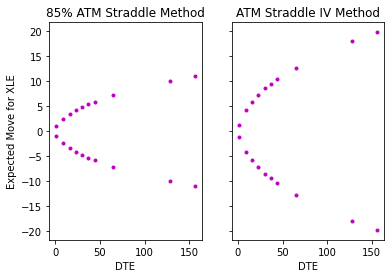

In [525]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True)

ax1.plot(combined.DTE, combined['85_method'],'m.')
ax1.set_title('85% ATM Straddle Method')
ax1.set_xlabel('DTE')
ax1.set_ylabel(f'Expected Move for {stock}')

ax2.plot(combined.DTE, combined.iv_method, 'm.')
ax2.set_title('ATM Straddle IV Method')
ax2.set_xlabel('DTE')